In [2]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader 
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

/Users/sarmadahmed/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv('nba_engineered_game_df.csv')
df = df.drop(columns=['matchup_id', 'date', 'next_matchup_date', 'Team_A', 'Team_B'])

In [4]:
pd.set_option('display.max_columns',None)
df.head()

,Team_A_+/-_basic_max,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_totals,Team_A_GmSc_basic_max,Team_A_ORtg_advanced_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_TS%_advanced_totals,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_ORtg_advanced_totals,Team_B_TS%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_totals_last5,Team_A_FG_basic_max_last5,Team_A_GmSc_basic_max_last5,Team_A_ORtg_advanced_max_last5,Team_A_ORtg_advanced_totals_last5,Team_A_PTS_basic_max_last5,Team_A_Q1_last5,Team_A_TS%_advanced_totals_last5,Team_A_USG%_advanced_max_last5,Team_A_eFG%_advanced_totals_last5,Team_B_win_last5,Team_B_+/-_basic_max_last5,Team_B_3PAr_advanced_max_last5,Team_B_DRtg_advanced_max_last5,Team_B_DRtg_advanced_totals_last5,Team_B_FG%_basic_totals_last5,Team_B_GmSc_basic_max_last5,Team_B_ORtg_advanced_max_last5,Team_B_ORtg_advanced_totals_last5,Team_B_PTS_basic_max_last5,Team_B_TRB%_advanced_totals_last5,Team_B_TS%_advanced_max_last5,Team_B_TS%_advanced_totals_last5,Team_B_eFG%_advanced_max_last5,Team_B_eFG%_advanced_totals_last5,Team_A_win_last10,Team_A_+/-_basic_max_last10,Team_A_3P%_basic_totals_last10,Team_A_DRtg_advanced_max_last10,Team_A_DRtg_advanced_totals_last10,Team_A_FG%_basic_totals_last10,Team_A_FGA_basic_max_last10,Team_A_FG_basic_max_last10,Team_A_FT_basic_max_last10,Team_A_GmSc_basic_max_last10,Team_A_ORtg_advanced_max_last10,Team_A_ORtg_advanced_totals_last10,Team_A_PTS_basic_max_last10,Team_A_PTS_basic_totals_last10,Team_A_Q1_last10,Team_A_TRB%_advanced_totals_last10,Team_A_TS%_advanced_max_last10,Team_A_TS%_advanced_totals_last10,Team_A_USG%_advanced_max_last10,Team_A_eFG%_advanced_totals_last10,Team_B_win_last10,Team_B_+/-_basic_max_last10,Team_B_3P%_basic_totals_last10,Team_B_3PAr_advanced_max_last10,Team_B_DRB_basic_totals_last10,Team_B_DRtg_advanced_max_last10,Team_B_DRtg_advanced_totals_last10,Team_B_FG%_basic_totals_last10,Team_B_FG_basic_max_last10,Team_B_FT_basic_max_last10,Team_B_GmSc_basic_max_last10,Team_B_ORtg_advanced_max_last10,Team_B_ORtg_advanced_totals_last10,Team_B_PTS_basic_max_last10,Team_B_PTS_basic_totals_last10,Team_B_TRB%_advanced_totals_last10,Team_B_TS%_advanced_max_last10,Team_B_TS%_advanced_totals_last10,Team_B_USG%_advanced_max_last10,Team_B_eFG%_advanced_max_last10,Team_B_eFG%_advanced_totals_last10,H2H_last5_Team_A_+/-_basic_max,H2H_last5_Team_A_AST_basic_max,H2H_last5_Team_A_AST_basic_totals,H2H_last5_Team_A_BLK_basic_totals,H2H_last5_Team_A_DRB_basic_totals,H2H_last5_Team_A_DRtg_advanced_max,H2H_last5_Team_A_DRtg_advanced_totals,H2H_last5_Team_A_FG%_basic_totals,H2H_last5_Team_A_FG_basic_max,H2H_last5_Team_A_FG_basic_totals,H2H_last5_Team_A_GmSc_basic_max,H2H_last5_Team_A_ORtg_advanced_totals,H2H_last5_Team_A_PTS_basic_max,H2H_last5_Team_A_PTS_basic_totals,H2H_last5_Team_A_Q1,H2H_last5_Team_A_Q3,H2H_last5_Team_A_TRB%_advanced_totals,H2H_last5_Team_A_TRB_basic_totals,H2H_last5_Team_A_TS%_advanced_totals,H2H_last5_Team_A_eFG%_advanced_totals,H2H_last5_Team_B_+/-_basic_max,H2H_last5_Team_B_BLK_basic_totals,H2H_last5_Team_B_DRB_basic_totals,H2H_last5_Team_B_DRtg_advanced_max,H2H_last5_Team_B_DRtg_advanced_totals,H2H_last5_Team_B_FG%_basic_totals,H2H_last5_Team_B_GmSc_basic_max,H2H_last5_Team_B_ORtg_advanced_totals,H2H_last5_Team_B_PTS_basic_totals,H2H_last5_Team_B_Q1,H2H_last5_Team_B_TRB%_advanced_totals,H2H_last5_Team_B_TRB_basic_totals,H2H_last5_Team_B_TS%_advanced_totals,H2H_last5_Team_B_eFG%_advanced_totals,Team_A_Elo_after_current_game,Team_B_Elo_after_current_game,Team_A_Elo_before_next_matchup,Team_B_Elo_before_next_matchup,elo_diff_before_next_matchup,Elo_diff_after_current_game,Team_A_Season_WinPct_after_current,Team_B_Season_WinPct_after_current,Team_A_Season_WinPct_before_next_matchup,Team_B_Season_WinPct_before_next_matchup,Team_A_H2H_WinPct_before_next_matchup,Team_B_H2H_WinPct_b

In [5]:
train_size = int(0.7 * len(df))  
val_size = int(0.15 * len(df))   
test_size = len(df) - train_size - val_size  

y = df['Team_A_win_next']
df = df.drop(columns=['Team_A_win_next'])

x_train = df.iloc[:train_size]
x_val = df.iloc[train_size:train_size+val_size]
x_test = df.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_train = y_train.to_numpy().reshape(-1,1)
y_val = y.iloc[train_size:train_size+val_size]
y_val = y_val.to_numpy().reshape(-1,1)
y_test = y.iloc[train_size+val_size:]
y_test = y_test.to_numpy().reshape(-1,1)


In [6]:
all_columns = df.columns.tolist()
binary_cols = [col for col in x_train.columns if x_train[col].nunique() == 2]
normalize_cols = [col for col in all_columns if col not in binary_cols]
normalize_indices = [all_columns.index(col) for col in normalize_cols]

mean = x_train[normalize_cols].mean().values
std = x_train[normalize_cols].std().values
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()

x_train[:, normalize_indices] = (x_train[:, normalize_indices] - mean) / std
x_val[:, normalize_indices] = (x_val[:, normalize_indices] - mean) / std
x_test[:, normalize_indices] = (x_test[:, normalize_indices] - mean) / std

In [7]:
device = torch.device('mps')
print(f'Using device: {device}')

x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

x_train = x_train.to(torch.float32).to(device)
x_val = x_val.to(torch.float32).to(device)
x_test = x_test.to(torch.float32).to(device)
y_train = y_train.to(torch.float32).to(device)
y_val = y_val.to(torch.float32).to(device)
y_test = y_test.to(torch.float32).to(device)


Using device: mps


In [8]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
x_train.shape 

torch.Size([13108, 158])

In [13]:
class baseline_nn(nn.Module): 
    def __init__(self): 
        super(baseline_nn, self).__init__() 
        self.fc1 = nn.Linear(158, 96)
        self.bn1 = nn.BatchNorm1d(96)
        self.fc2 = nn.Linear(96, 48) # Input size 128, output size 64 
        self.bn2 = nn.BatchNorm1d(48)
        self.fc3 = nn.Linear(48, 24)
        self.bn3 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24, 1)
        self.relu = nn.ReLU() # ReLU activation 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.bn1(x)
        x = self.relu(x) 
        x = self.dropout(x)
        
        x = self.fc2(x) 
        x = self.bn2(x)
        x = self.relu(x) 
        x = self.dropout(x)
        
        x = self.fc3(x) 
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x) 
        return x

In [14]:
model = baseline_nn() 
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.002) 
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, verbose=True)

##Early stopping parameters  
best_val_loss = float('inf') 
patience = 5
patience_cntr = 0 
best_model_State = None 

In [15]:
epochs = 40

# training 
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for batch_data, batch_labels in train_dataloader: # Forward pass 
        logits = model(batch_data)                               
        loss = criterion(logits, batch_labels)  # per batch loss 
        optimizer.zero_grad() # Backward pass 
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_data.size(0) 
        #total batch loss = loss per batch * num samples in batch
        # summing total loss for all batches in 1 epoch 
    train_loss = running_train_loss / len(train_dataset) # avg loss per sample

#validation 
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # Turn off gradient calculation for evaluation 
        for batch_data, batch_labels in val_dataloader:
            logits = model(batch_data)
            loss = criterion(logits, batch_labels)
            running_val_loss += loss.item() * batch_data.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.50).float()
           
            correct += (preds == batch_labels).sum().item()
            total += batch_labels.numel()

    val_loss = running_val_loss / len(val_dataset)
    val_acc = 100.0 * correct / total
    
    print(f"Epoch [{epoch+1}/{epochs}]  " f"Train Loss: {train_loss:.4f}  " f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss: 
        best_val_loss = val_loss 
        patience_cntr = 0           
        best_model_state = model.state_dict() 
    else: 
        patience_cntr += 1 
        if patience_cntr == patience: 
            print(f'Early stopping at epoch {epoch+1} . Validation loss did not improve for {patience} epochs.') 
            break 

Epoch [1/40]  Train Loss: 0.6757  Val Loss: 0.6610  Val Acc: 59.94%
Epoch [2/40]  Train Loss: 0.6473  Val Loss: 0.6523  Val Acc: 61.22%
Epoch [3/40]  Train Loss: 0.6442  Val Loss: 0.6497  Val Acc: 61.04%
Epoch [4/40]  Train Loss: 0.6357  Val Loss: 0.6474  Val Acc: 62.32%
Epoch [5/40]  Train Loss: 0.6319  Val Loss: 0.6461  Val Acc: 62.22%
Epoch [6/40]  Train Loss: 0.6265  Val Loss: 0.6449  Val Acc: 62.57%
Epoch [7/40]  Train Loss: 0.6229  Val Loss: 0.6439  Val Acc: 63.14%
Epoch [8/40]  Train Loss: 0.6212  Val Loss: 0.6442  Val Acc: 63.53%
Epoch [9/40]  Train Loss: 0.6202  Val Loss: 0.6426  Val Acc: 63.00%
Epoch [10/40]  Train Loss: 0.6162  Val Loss: 0.6415  Val Acc: 62.89%
Epoch [11/40]  Train Loss: 0.6153  Val Loss: 0.6417  Val Acc: 63.14%
Epoch [12/40]  Train Loss: 0.6101  Val Loss: 0.6415  Val Acc: 63.32%
Epoch [13/40]  Train Loss: 0.6126  Val Loss: 0.6420  Val Acc: 63.43%
Epoch [14/40]  Train Loss: 0.6076  Val Loss: 0.6427  Val Acc: 63.11%
Epoch [15/40]  Train Loss: 0.6080  Val Loss

In [16]:
## final evaluation using model weights from best epoch 

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print('Loaded best model state from early stopping for final evaluation')
else:
    print('Early stopping did not trigger. Using model from the last epoch.')

val_preds_list = []
val_labels_list = []
model.eval() 
final_val_loss = 0.0
final_correct = 0
final_total = 0
with torch.no_grad():
    for batch_data, batch_labels in val_dataloader:
        logits = model(batch_data)
        loss = criterion(logits, batch_labels)
        final_val_loss += loss.item() * batch_data.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.50).float()
        
        val_preds_list.extend(preds.cpu().numpy().astype(int).tolist())
        val_labels_list.extend(batch_labels.cpu().numpy().astype(int).tolist())
        final_correct += (preds == batch_labels).sum().item()
        final_total += batch_labels.numel()

final_val_loss /= len(val_dataset)
final_val_acc = 100.0 * final_correct / final_total

print("\nBest Model Performance on Validation Set")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Acc: {final_val_acc:.2f}%")

Loaded best model state from early stopping for final evaluation

Best Model Performance on Validation Set
Final Val Loss: 0.6420
Final Val Acc: 63.11%


Validation AUROC: 0.6792


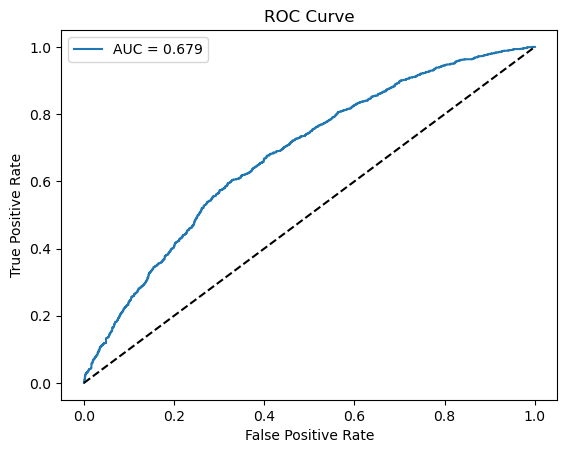

In [17]:
from sklearn.metrics import roc_auc_score
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_data, batch_labels in val_dataloader:
        logits = model(batch_data)
        probs = torch.sigmoid(logits)        
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(batch_labels.cpu().numpy().flatten())
auc = roc_auc_score(all_labels, all_probs)
print(f"Validation AUROC: {auc:.4f}")
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_acc = 0
best_thresh = 0.5
best_metrics = {}

thresholds = np.linspace(0, 1, 101)  # 0.00, 0.01, ..., 1.00
for t in thresholds:
    preds = (np.array(all_probs) >= t).astype(int)

    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)

    if acc > best_acc:   # pick by accuracy (could also pick by F1)
        best_acc = acc
        best_thresh = t
        best_metrics = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        }

print(f"Best Threshold: {best_thresh:.2f}")
print(f"Accuracy : {best_metrics['accuracy']:.4f}")
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall   : {best_metrics['recall']:.4f}")
print(f"F1 Score : {best_metrics['f1']:.4f}")

Best Threshold: 0.53
Accuracy : 0.6371
Precision: 0.6519
Recall   : 0.6027
F1 Score : 0.6263


TPR: 0.6288
FPR: 0.366
TNR: 0.634
FNR: 0.371


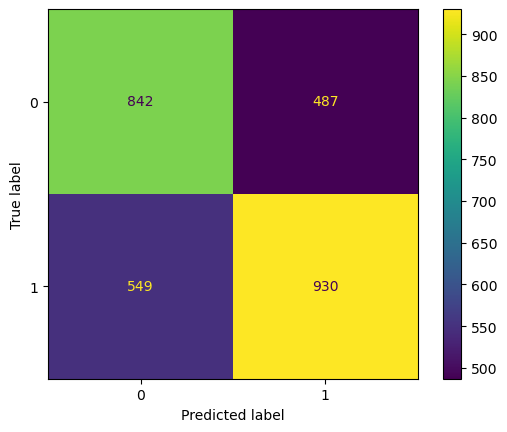

In [19]:
val_preds = np.array(val_preds_list, dtype=int) 
val_labels = np.array(val_labels_list, dtype=int)
conf_matrix = confusion_matrix(val_preds, val_labels)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")
